In [ ]:
!pip install datasets
!pip install torch
!pip install nltk
!pip install Lime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import re

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from collections import Counter

# Download necessary NLTK datasets
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from datasets import load_dataset
dataset = load_dataset("yelp_review_full")

README.md:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [ ]:
def map_stars_to_sentiment(label):
    if label in [0, 1]:  # Labels 0 and 1 are Negative
        return 'negative'
    elif label == 2:  # Label 2 is Neutral
        return 'neutral'
    elif label in [3, 4]:  # Labels 3 and 4 are Positive
        return 'positive'

In [ ]:
# Convert to Pandas DataFrame to view the first few rows
train_df = dataset['train'].to_pandas()

train_df['label'] = train_df['label'].apply(map_stars_to_sentiment)
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
train_df['label'] = train_df['label'].map(sentiment_mapping)
# Display the first few rows to check the sentiment mapping
train_df.head()

label                                               text
0      2  dr. goldberg offers everything i look for in a...
1      0  Unfortunately, the frustration of being Dr. Go...
2      2  Been going to Dr. Goldberg for over 10 years. ...
3      2  Got a letter in the mail last week that said D...
4      0  I don't know what Dr. Goldberg was like before...

In [ ]:
test_df = dataset['train'].to_pandas()

test_df['label'] = test_df['label'].apply(map_stars_to_sentiment)
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
test_df['label'] = test_df['label'].map(sentiment_mapping)
# Display the first few rows to check the sentiment mapping
test_df.head()

label                                               text
0      2  dr. goldberg offers everything i look for in a...
1      0  Unfortunately, the frustration of being Dr. Go...
2      2  Been going to Dr. Goldberg for over 10 years. ...
3      2  Got a letter in the mail last week that said D...
4      0  I don't know what Dr. Goldberg was like before...

In [ ]:
from datasets import Dataset, DatasetDict
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Step 1: Take a random sample of 50,000 from the train_df
train_sample = train_df.sample(n=50000, random_state=42).reset_index(drop=True)

# Step 2: Split into train and validation (e.g., 90/10)
train_split = train_sample.sample(frac=0.9, random_state=42).reset_index(drop=True)
val_split = train_sample.drop(train_split.index).reset_index(drop=True)

# Test Sample
test_sample = test_df.sample(n=25000, random_state=42).reset_index(drop=True)

# Step 3: Use 50% of the test_df
test_split = test_sample.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 4: Convert to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_split)
val_dataset = Dataset.from_pandas(val_split)
test_dataset = Dataset.from_pandas(test_split)

# Step 5: Create a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Optional: Print dataset sizes
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 45000
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 25000
    })
})


In [ ]:

# Print unique labels from the 'label' column of the training dataset
unique_labels = dataset['train']['label']
print("Unique labels in the training dataset:")
print(set(unique_labels))  # This will print all unique labels in the dataset



Unique labels in the training dataset:
{0, 1, 2}


In [ ]:
# Print the column names of the training dataset
print("Columns in the training dataset:")
print(dataset['train'].column_names)


Columns in the training dataset:
['label', 'text']


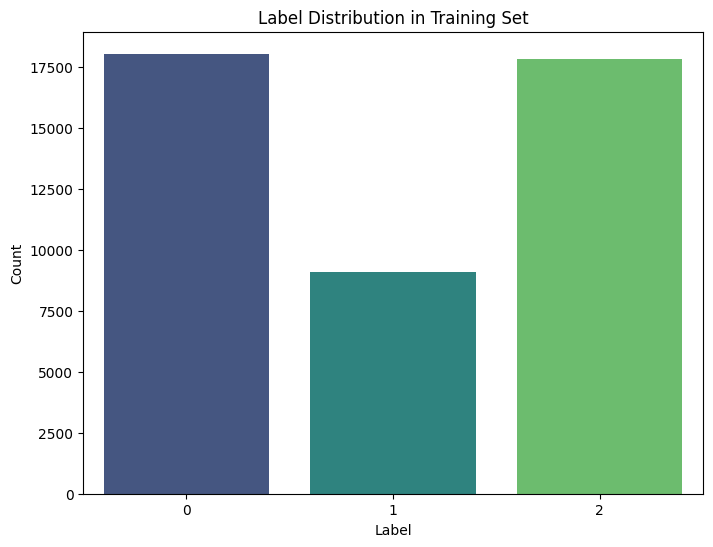

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Extract the labels from the training set
labels = dataset['train']['label']

# Count the occurrences of each label
label_counts = Counter(labels)

# Convert to list of labels and counts
labels_list = list(label_counts.keys())
counts_list = list(label_counts.values())

# Create a bar plot of the label distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=labels_list, y=counts_list, palette="viridis")

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Training Set')
plt.xticks(labels_list)  # Ensure the x-axis labels match the class labels

# Show the plot
plt.show()


# Review Length Analysis

In [ ]:
# Extract the Text from the training set
texts = dataset['train']['text']


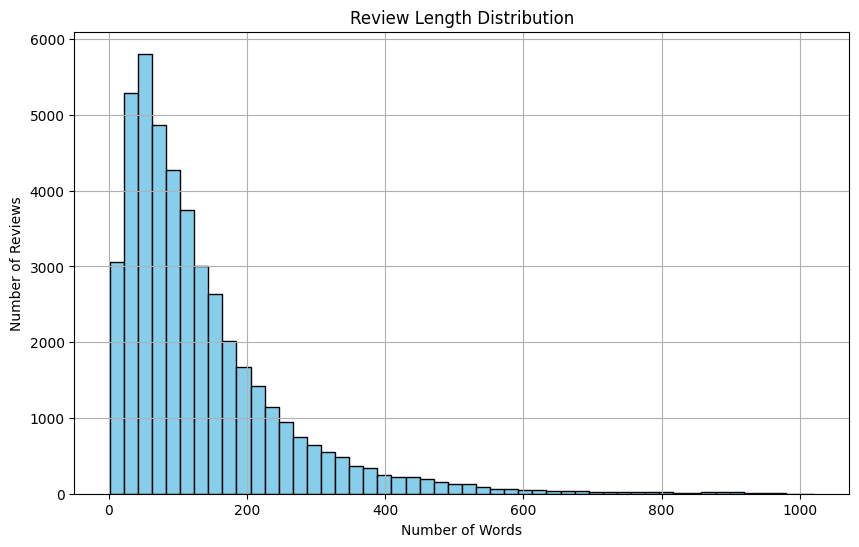

Average review length: 133.67
Max review length: 1021
Min review length: 1


In [ ]:
import matplotlib.pyplot as plt

# Assuming `texts` is your list of reviews
review_lengths = [len(text.split()) for text in texts]

plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()

print(f"Average review length: {np.mean(review_lengths):.2f}")
print(f"Max review length: {np.max(review_lengths)}")
print(f"Min review length: {np.min(review_lengths)}")


# Data Preprocessing , Tokenization & Building Vocabulary

In [ ]:
# Initialize NLTK components
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
# Tokenization + Lemmatization + Stopwords removal function
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

In [ ]:
# Example: Preprocess the dataset
tokenized_texts = [preprocess_text(example['text']) for example in tqdm(dataset['train'])]


# Build the vocabulary
flat_tokens = [token for tokens in tokenized_texts for token in tokens]  # Flatten list of tokens
vocab = Counter(flat_tokens)

min_freq = 10
vocab_filtered = {word: freq for word, freq in vocab.items() if freq >= min_freq}
vocab_sorted = sorted(vocab_filtered.items(), key=lambda x: x[1], reverse=True)  # Sorting by frequency
word2idx = {word: idx + 2 for idx, (word, _) in enumerate(vocab_sorted)}  # Starting from index 2 (0 for PAD, 1 for SOS/EOS)
word2idx['<pad>'] = 0  # Adding PAD token
word2idx['<sos>'] = 1  # Adding SOS token
word2idx['<eos>'] = 2  # Adding EOS token
word2idx['<unk>'] = len(word2idx)  # Adding UNK token

100%|██████████| 45000/45000 [00:57<00:00, 780.71it/s]


In [ ]:
# Printing the first few items of the vocabulary to verify
print("Vocabulary:", list(word2idx.items())[:10])

Vocabulary: [('place', 2), ('food', 3), ('good', 4), ('like', 5), ('time', 6), ('get', 7), ('one', 8), ('would', 9), ('service', 10), ('great', 11)]


In [ ]:
print(f"Original vocab size : {len(vocab)}")
print(f"Final vocab size (including special tokens): {len(word2idx)}")

Original vocab size : 49990
Final vocab size (including special tokens): 11440


In [ ]:
MAX_LEN = 200

def text_to_sequence(tokens, word2idx, max_len=MAX_LEN):
    sequence = [word2idx.get('<sos>')] + [word2idx.get(token, word2idx['<unk>']) for token in tokens] + [word2idx.get('<eos>')]
    # Pad or truncate
    if len(sequence) < max_len:
        sequence += [word2idx['<pad>']] * (max_len - len(sequence))
    else:
        sequence = sequence[:max_len]
    return sequence


## Custom PyTorch Dataset

In [ ]:
import torch
from torch.utils.data import Dataset

class YelpReviewDataset(Dataset):
    def __init__(self, data, word2idx, max_len=MAX_LEN):
        self.data = data
        self.word2idx = word2idx
        self.max_len = max_len
        self.samples = []

        for example in tqdm(data):
            tokens = preprocess_text(example['text'])
            input_ids = text_to_sequence(tokens, word2idx, self.max_len)
            label = int(example['label'])  # Labels are 0 to 4
            self.samples.append((input_ids, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input_ids, label = self.samples[idx]
        return torch.tensor(input_ids), torch.tensor(label)


## Creating Datasets & DataLoaders

In [ ]:
from torch.utils.data import DataLoader

train_dataset = YelpReviewDataset(dataset['train'], word2idx)
val_dataset = YelpReviewDataset(dataset['validation'], word2idx)
test_dataset = YelpReviewDataset(dataset['test'], word2idx)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)



100%|██████████| 25000/25000 [00:31<00:00, 804.45it/s]


## Subset of Train dataset

In [ ]:
# Subset the training data for hyperparameter tuning
sample_ratio = 0.15  # 15% of the training data
sample_size = int(len(train_loader.dataset) * sample_ratio)
indices = np.random.choice(len(train_loader.dataset), sample_size, replace=False)
train_loader_subset = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_loader.dataset, indices),
    batch_size=32, shuffle=True
)

In [ ]:
# Get the number of samples in the train_loader_subset
train_data_size = len(train_loader_subset.dataset)
print(f"Number of samples in train_loader_subset: {train_data_size}")


Number of samples in train_loader_subset: 6750


## LSTM+Attention Model
- LSTM (Long Short-Term Memory) handles sequence data well and remembers long-term dependencies.
- Attention mechanism helps the model focus on the most relevant parts of the sequence, improving performance, especially on longer inputs.

In [ ]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers
                 , dropout, pad_idx):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                             dropout=dropout, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        self.hidden_dim = hidden_dim

        self.attn_fc = nn.Linear(hidden_dim, 1)
        self.output_fc = nn.Linear(hidden_dim, output_dim)

    def attention_net(self, lstm_output):
        # lstm_output: [batch_size, seq_len, hidden_dim*2]
        attn_weights = torch.softmax(self.attn_fc(lstm_output), dim=1)  # [batch_size, seq_len, 1]
        context = torch.sum(attn_weights * lstm_output, dim=1)  # [batch_size, hidden_dim*2]
        return context

    def forward(self, text):
        embedded = self.embedding(text)  # [batch_size, seq_len, emb_dim]
        lstm_output, _ = self.lstm(embedded)  # [batch_size, seq_len, hidden_dim * num_directions]
        context = self.attention_net(lstm_output)  # [batch_size, hidden_dim * num_directions]
        context = self.dropout(context)
        output = self.output_fc(context)  # [batch_size, output_dim]
        return output



# Functions for Early Stopping, Build, Train and Evaluate

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
def build_model(embedding_dim, hidden_dim, n_layers, dropout):
    model = LSTMClassifier(
        vocab_size=len(word2idx),
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        output_dim=3,
        n_layers=n_layers,
        dropout=dropout,
        pad_idx=word2idx['<pad>']
    )
    return model.to(device)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, early_stopping):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        scheduler.step(val_loss)  # Adjust learning rate based on val loss

        # Save to history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if early_stopping:
          early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return history



In [ ]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Hyperparameter Tuning

In [ ]:
#Hyperparameter Grid
from itertools import product

hyperparams_grid = {
    'embedding_dim': [100,128],
    'hidden_dim': [64, 128],
    'n_layers': [1,2],
    'dropout': [0.3, 0.5],
}

# Generate all combinations
param_combinations = list(product(
    hyperparams_grid['embedding_dim'],
    hyperparams_grid['hidden_dim'],
    hyperparams_grid['n_layers'],
    hyperparams_grid['dropout'],
))


In [ ]:
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def evaluate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

best_loss = float('inf')
best_params = None
best_model_state = None


for (embedding_dim, hidden_dim, n_layers, dropout) in param_combinations:
    start_time = time.time()
    print(f"Trying: emb={embedding_dim}, hid={hidden_dim}, layers={n_layers}, drop={dropout}")

    model = build_model(embedding_dim, hidden_dim, n_layers, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Training only for a few epochs for tuning
    for epoch in range(5):
        model.train()
        for batch in train_loader_subset:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    val_loss = evaluate_model(model, val_loader, criterion)
    print(f"Validation Loss: {val_loss:.4f}")

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Elapsed time for this trial: {elapsed_time:.2f} seconds")
    print("-------------------------------------------------------")


    if val_loss < best_loss:
        best_loss = val_loss
        best_params = (embedding_dim, hidden_dim, n_layers, dropout)
        best_model_state = model.state_dict()

Trying: emb=100, hid=64, layers=1, drop=0.3
Validation Loss: 0.7405
Elapsed time for this trial: 10.61 seconds
-------------------------------------------------------
Trying: emb=100, hid=64, layers=1, drop=0.5
Validation Loss: 0.8052
Elapsed time for this trial: 5.24 seconds
-------------------------------------------------------
Trying: emb=100, hid=64, layers=2, drop=0.3
Validation Loss: 0.7720
Elapsed time for this trial: 5.61 seconds
-------------------------------------------------------
Trying: emb=100, hid=64, layers=2, drop=0.5
Validation Loss: 0.7739
Elapsed time for this trial: 5.72 seconds
-------------------------------------------------------
Trying: emb=100, hid=128, layers=1, drop=0.3
Validation Loss: 0.7914
Elapsed time for this trial: 5.20 seconds
-------------------------------------------------------
Trying: emb=100, hid=128, layers=1, drop=0.5
Validation Loss: 0.7562
Elapsed time for this trial: 5.24 seconds
-------------------------------------------------------
T

# Saving the Best Parameters

In [ ]:
# Save best model params
print("\nBest Hyperparameters:")
print(f"Embedding Dim: {best_params[0]}, Hidden Dim: {best_params[1]}, Layers: {best_params[2]}, Dropout: {best_params[3]}")



Best Hyperparameters:
Embedding Dim: 100, Hidden Dim: 128, Layers: 2, Dropout: 0.3


# Final Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Rebuild and load best model
final_model = build_model(*best_params)
final_model.load_state_dict(best_model_state)

# Define optimizer/criterion again
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


early_stopping = EarlyStopping(patience=3, min_delta=0.01)
# Train with early stopping now
final_history = train_model(
    final_model,
    train_loader,
    val_loader,
    criterion,         # criterion comes first
    optimizer,
    epochs=15,
    early_stopping=early_stopping
)

Epoch [1/15] Train Loss: 0.6262, Train Acc: 0.7350, Val Loss: 0.5475, Val Acc: 0.7758
Epoch [2/15] Train Loss: 0.5461, Train Acc: 0.7720, Val Loss: 0.4926, Val Acc: 0.7998
Epoch [3/15] Train Loss: 0.4830, Train Acc: 0.7997, Val Loss: 0.4287, Val Acc: 0.8266
Epoch [4/15] Train Loss: 0.4209, Train Acc: 0.8270, Val Loss: 0.3715, Val Acc: 0.8578
Epoch [5/15] Train Loss: 0.3434, Train Acc: 0.8629, Val Loss: 0.3070, Val Acc: 0.8928
Epoch [6/15] Train Loss: 0.2645, Train Acc: 0.8991, Val Loss: 0.2525, Val Acc: 0.9204
Epoch [7/15] Train Loss: 0.1927, Train Acc: 0.9286, Val Loss: 0.2271, Val Acc: 0.9358
Epoch [8/15] Train Loss: 0.1366, Train Acc: 0.9506, Val Loss: 0.2124, Val Acc: 0.9472
Epoch [9/15] Train Loss: 0.0987, Train Acc: 0.9656, Val Loss: 0.2193, Val Acc: 0.9448
Epoch [10/15] Train Loss: 0.0773, Train Acc: 0.9736, Val Loss: 0.2081, Val Acc: 0.9548
Epoch [11/15] Train Loss: 0.0565, Train Acc: 0.9806, Val Loss: 0.2335, Val Acc: 0.9550
Early stopping at epoch 11


# Save the Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# Define a path on Google Drive where you want to save the model
drive_path = '/content/drive/My Drive/lstm_models'

# Create the folder if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# Save the model to Google Drive
torch.save(final_model.state_dict(), f'{drive_path}/best_model.pth')

# Save word2idx to Google Drive
torch.save(word2idx, f'{drive_path}/word2idx.pth')


## Visualization - Train and Validation Accuracy & Loss over Epcohs




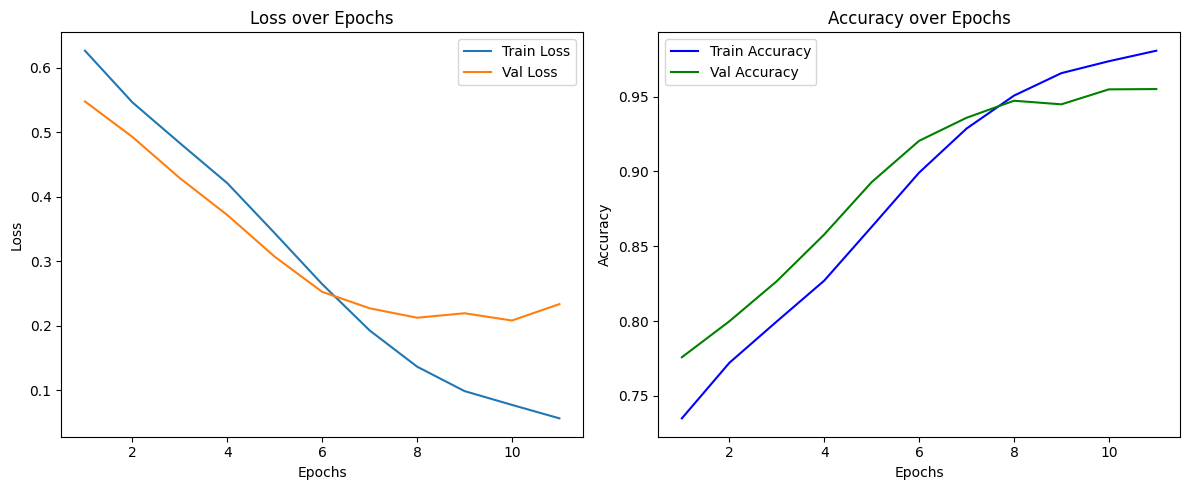

In [ ]:
def plot_training_history(history):
    import matplotlib.pyplot as plt

    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label='Train Loss')
    plt.plot(epochs, history["val_loss"], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label='Train Accuracy', color='Blue')
    plt.plot(epochs, history["val_acc"], label='Val Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(final_history)



# Evaluation on Test Data

In [ ]:
def evaluate_on_test(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy, all_preds, all_labels


In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
def print_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)


Test Loss: 0.2258, Test Accuracy: 0.9566


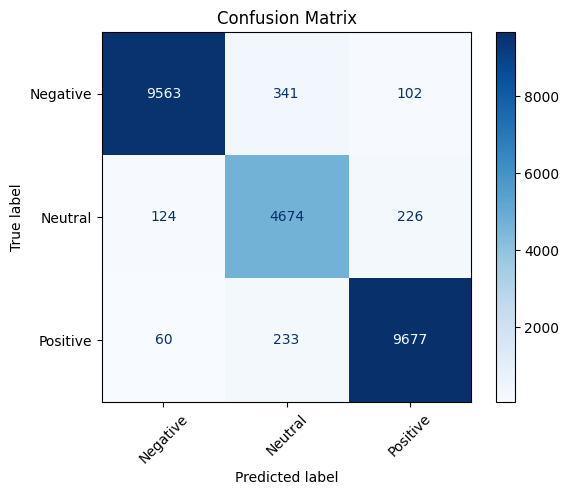

              precision    recall  f1-score   support

    Negative       0.98      0.96      0.97     10006
     Neutral       0.89      0.93      0.91      5024
    Positive       0.97      0.97      0.97      9970

    accuracy                           0.96     25000
   macro avg       0.95      0.95      0.95     25000
weighted avg       0.96      0.96      0.96     25000



In [ ]:
# Evaluate on test set
test_loss, test_accuracy, y_pred, y_true = evaluate_on_test(final_model, test_loader, criterion)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Results
class_names = ['Negative', 'Neutral', 'Positive']

plot_confusion_matrix(y_true, y_pred, class_names)
print_classification_report(y_true, y_pred, class_names)


# LIME for Word Importance

In [ ]:
from lime.lime_text import LimeTextExplainer
import numpy as np

# A wrapper to make your PyTorch model work with LIME
class PredictWrapper:
    def __init__(self, model, word2idx, max_len=100):
        self.model = model
        self.word2idx = word2idx
        self.max_len = max_len
        self.model.eval()

    def preprocess(self, texts):
        tokenized = [text.lower().split() for text in texts]
        indexed = [[self.word2idx.get(w, self.word2idx["<unk>"]) for w in sent] for sent in tokenized]
        padded = [s + [self.word2idx["<pad>"]] * (self.max_len - len(s)) if len(s) < self.max_len else s[:self.max_len] for s in indexed]
        return torch.tensor(padded)

    def __call__(self, texts):
        inputs = self.preprocess(texts).to(device)
        with torch.no_grad():
            outputs = self.model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
        return probs

In [ ]:
explainer = LimeTextExplainer(class_names=['Negative', 'Neutral', 'Positive'])
predict_fn = PredictWrapper(final_model, word2idx)

In [ ]:
# Positive
pos_text = "The food was amazing and the staff were super friendly!"
exp = explainer.explain_instance(pos_text, predict_fn, num_features=10)
exp.show_in_notebook(text=pos_text)  # or exp.as_list()

In [ ]:
# Negative
neg_text = "Absolutely terrible experience. I’m never coming back"
exp = explainer.explain_instance(neg_text, predict_fn, num_features=10)
exp.show_in_notebook(text=neg_text)  # or exp.as_list()

In [ ]:
# Neutral
neutral_text = "Decent food, but service was slow and rude."
exp = explainer.explain_instance(neutral_text, predict_fn, num_features=10)
exp.show_in_notebook(text=neutral_text)  # or exp.as_list()

#  performance by review length

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import torch
import pandas as pd

def evaluate_lstm_by_length(model, preprocess_text, word2idx, dataset, device, max_len=200):
    model.eval()
    length_bins = [(0, 50), (51, 100), (101, 200), (201, 10000)]
    results = []

    # Extract raw text and labels
    texts = [example['text'] for example in dataset]
    labels = [example['label'] for example in dataset]

    for min_len, max_len_bin in length_bins:
        indices = [i for i, text in enumerate(texts) if min_len <= len(text.split()) <= max_len_bin]
        if not indices:
            continue

        X_bin = [text_to_sequence(preprocess_text(texts[i]), word2idx, max_len=max_len) for i in indices]
        y_bin = [labels[i] for i in indices]

        inputs_tensor = torch.tensor(X_bin).to(device)

        with torch.no_grad():
            logits = model(inputs_tensor)
            preds = torch.argmax(logits, dim=1).cpu().numpy()

        acc = accuracy_score(y_bin, preds)
        f1 = f1_score(y_bin, preds, average='weighted')
        results.append({
            'Length': f"{min_len}-{max_len_bin}",
            'Accuracy': acc,
            'F1 Score': f1,
            'Sample Size': len(indices)
        })

    return pd.DataFrame(results)


In [ ]:
length_eval_df = evaluate_lstm_by_length(
    model=final_model,
    preprocess_text=preprocess_text,
    word2idx=word2idx,
    dataset=dataset['test'],
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

print(length_eval_df)


      Length  Accuracy  F1 Score  Sample Size
0       0-50  0.960507  0.960745         6077
1     51-100  0.956528  0.956746         6717
2    101-200  0.956062  0.956284         7283
3  201-10000  0.952468  0.952894         4923


In [ ]:
import matplotlib.pyplot as plt

def plot_lime_token_importance(lime_exp):
    tokens, weights = zip(*lime_exp.as_list())
    plt.figure(figsize=(10, 4))
    plt.barh(tokens[::-1], weights[::-1], color='skyblue')
    plt.xlabel("Importance")
    plt.title("Token Influence (LIME)")
    plt.tight_layout()
    plt.show()


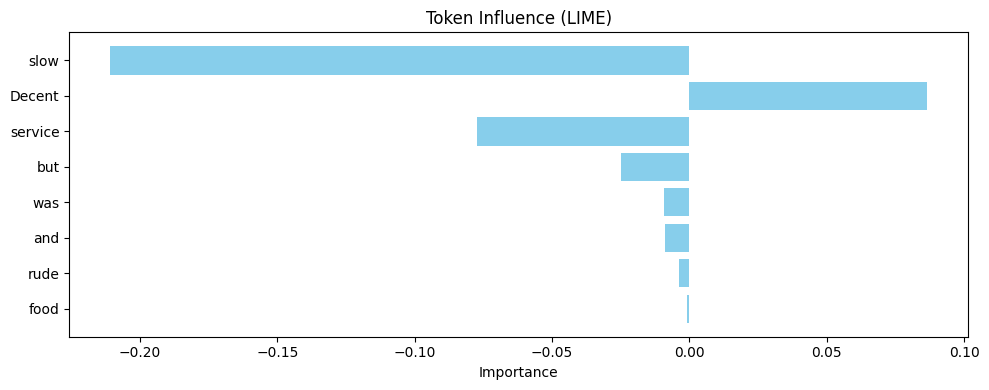

In [ ]:
plot_lime_token_importance(exp)
